Tweet intake example:

In [ ]:
#class override- apparently this is SOP for tweepy
class Listener(tweepy.StreamListener):
    
    def on_status(self,status):
        is_retweet = False
        #rt flag, start with false as default
        retweet_text= ""
        if hasattr(status, "retweeted_status"):
            is_retweet=True
            try:
                retweet_text = status.retweeted_status.extended_tweet["full_text"]
            except:
                retweet_text = status.retweeted_status.text
        
        #handles 140+ character tweets
        if hasattr(status, "extended_tweet"):
            text = status.extended_tweet["full_text"]
        else:
            text = status.text
        
        
        quoted_text =""
        if hasattr(status, "quoted_status"):
            #check if the QT was 140+ char
            if hasattr(status.quoted_status,"extended_tweet"):
                quoted_text = status.quoted_status.extended_tweet['full_text']
            else:
                quoted_text = status.quoted_status.text
                
        #some minor text-pre-processing to remove newlines and commas incase those become relevant
        remove = [',','\n']
        for i in remove:
            text = text.replace(i," ")
            quoted_text = quoted_text.replace(i," ")
            retweet_text = retweet_text.replace(i," ")
            
        with open("nlpdata.csv","a",encoding='utf-8') as f:
             f.write("%s,%s,%s,%s,%s,%s\n"%(status.user.screen_name,is_retweet,status.created_at,text,quoted_text,retweet_text))
        #db.processTest.insert({'handle':status.user.screen_name,'RT TF':is_retweet,'time':status.created_at,'tweet':text,'qt':quoted_text,'rt':retweet_text,'in_keyword_db':0})
    def on_error(self,status_code):
        print("Encountered streaming error (", status_code, ")")
        sys.exit()
    
    #def on_data(self,data):
        #print(data)

The tags variable below shows some example search terms used to build the dataset. Been saving to file for these, just to maintain the segmentation between search term datasets

In [ ]:
streamListener = Listener()
stream = tweepy.Stream(auth=api.auth, listener=streamListener, tweet_mode='extended')
with open('nlpdata.csv',"w",encoding='utf-8') as f:
    f.write("handle,is_rt,date,tweet,qt,rt")
tags = ["biden",'joe biden','obama','trump','donald trump','pelosi','congress','senate'] #= ['python']
stream.filter(languages=["en"], track=tags)

Quick look into what some word clouds would look like on some of the datasets:

In [ ]:
df = pd.read_csv('trump1.csv',error_bad_lines=False)
#in this case dataset is based on search terms for 'trump'
tweets = df['tweet']
#been having some erroneous lines for mysterious reasons, hence the error_bad_lines=False
tweets.dropna()

Pre-processing method that I've been using, this is definitely still subject to change, for reasons you'll see momentarily

In [ ]:
from nltk.stem.snowball import SnowballStemmer
import string

#Create the function that performs the text conversion
sn = SnowballStemmer('english')

def clean_text(text, sn=sn):
    #special case of getting rid of RT info
    rt_re = re.compile('^RT @[a-zA-Z0-9]+:')
    text = rt_re.sub(' ',text)
    #removing other @ instances
    ats_re = re.compile('^@[a-zA-Z0-9]+')
    text = ats_re.sub(' ',text)
    #remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    #removing punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation + '£'))
    text = punc_re.sub(' ', ' '+text.lower()+' ') # Pad with spaces for easier stopword removal
    # Remove numbers
    num_re = re.compile('(\\d+)')
    text = num_re.sub(' ', text)
    # Remove alphanumerical words
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    text = alpha_num_re.sub(' ', text)
    # Stemming
    text = sn.stem(text)
    # Regex for multiple spaces
    spaces_re = re.compile('\s+')
    text = spaces_re.sub(' ', text.strip())

    return text


In [ ]:
tweets = tweets.apply(str) #might not handle emojis well, will want to look into that
tweets = tweets.apply(clean_text)

In [ ]:
CVStop = CountVectorizer(ngram_range=(1,1),stop_words='english')
withStops = CVStop.fit_transform(tweets)
withStops

In [ ]:
def create_wordcloud(wordcloud_series):
    df_text = ' '.join(str(wordcloud_series).lower() for v in wordcloud_series)
    wordcloud = WordCloud(stopwords = None,
                      collocations=True).generate(df_text)
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.show()
    
    
create_wordcloud(tweets)

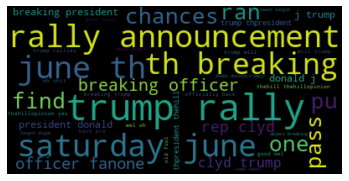

Also, been playing around with tNSE on a 'reduced' dataset (as in, not full), get some not great results but this is still WIP:

In [ ]:
withStopDF = pd.DataFrame(withStops.toarray(), columns = CVStop.get_feature_names())
attempt2 = TSNE().fit_transform(withStopDF)
x2 = [i[0] for i in attempt2]
y2 = [i[1] for i in attempt2]
plt.scatter(x2,y2)

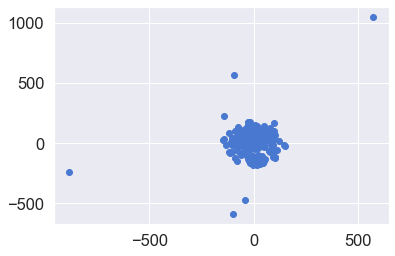

So can maaaybe see two clusters here, but honestly the actual end result here is less important than that the code is now available and workflow known :)

Lastly, let's take a quick look into what topics we can extract out of a dataset. Taking Nick's example workflow, using the above clean_text as our preprocessor;

In [ ]:
def make_topics(docs, preprocessor, vectorizer, topic_modeler, print_n_words=15):
    """A very simple pipeline."""
    
    # Apply preprocessor, vectorizer, and topic modeler.
    if preprocessor is not None:
        docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors

In [ ]:
#Using NMF and TF-IDF for tokenization;
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [ ]:
preprocessor = clean_text
vectorizer = TfidfVectorizer()
topic_modeler = NMF(10, random_state=10, max_iter=1000)  #random state arbitrary

make_topics(tweets, preprocessor, vectorizer, topic_modeler);

Sample output:

Topic 0:
 ORGANIZE, HELPED, REPORTS, FEC, POINT, CAMPAIGN, MILLION, JAN, SHOW, PAID, SOME, OVER, WHO, AT, PEOPLE 

Topic 1:
 THE, OF, TO, TRUMP, ON, IS, AND, BIDEN, IT, SENATE, WILL, VOTE, IF, THAT, NOT 

Topic 2:
 QAYI, CONTEXT, CO, HTTPS, FOR, ROXN, EX, BIDEN, TRUMP, OBAMA, HOST, NEWS, UNVEILING, SKIPPED, REPORT 

Topic 3:
 THAT, GAS, UNEMPLOYMENT, JUNE, MENTION, FORGOT, PRICES, SAME, WA, TIME, LAST, YEAR, OR, NOW, WERE 

Topic 4:
 IS, THE, RUNNER, FRONT, FUL, MISSOURI, SEAT, PROOF, GUY, NEED, GOING, BEING, GOP, ALL, THIS 

Topic 5:
 IGNORING, PRESIDENT, CRISIS, BORDER, JORDAN, BIDENS, JIM, RT, VICE, CONGRES, HARRIS, JUNE, DEMOCRATS, THE, ECONOMY 

Topic 6:
 HE, WHEN, WITH, NYPD, BESIDES, VEHICLES, ARRIVED, HELMETS, TT, SUV, COPS, SHUT, NIGHT, ST, DOWN 

Topic 7:
 IN, HASN, FUCKING, SINGLE, GETS, PASSED, PER, BEEN, YEARS, CONGRESS, JIM, JORDAN, HAS, ONE, BILL 

Topic 8:
 TO, VOTERS, INSTEAD, YOURE, TRY, SUPPOSED, LOSE, TRYING, WIN, YOU, STOP, MORE, REPUBLICANS, ELECTION, AN 

Topic 9:
 SEN, SEPARATE, MEETINGS, KYRSTEN, PHIL, SINEMA, MAT, VIRGINIA, MET, MANCHIN, WEST, INFRASTRUCTURE, ARIZONA, JOE, BIDEN 

Honestly, I would argue this did okay. Pretty concise topics, sorta. Big issue would be to do better on the pre-processing bit so i don't have dumb stuff like 'https' in my topics :).